In [1]:

import os.path
from pathlib import Path
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.express as px

from utils.util import *

In [2]:
output_dir = "population_analysis"
Path(output_dir).mkdir(parents=True, exist_ok=True)
figwi = 12

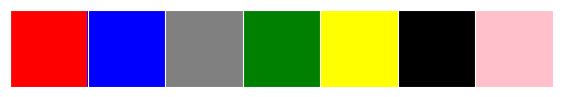

In [3]:
color_palette = ["red", "blue", "gray", "green", "yellow", "black", "pink"]
sns.set_palette(color_palette)
sns.palplot(sns.color_palette())

In [4]:
real_data_1000_genome = load_real_data(hapt_genotypes_path=f"../{REAL_10K_SNP_1000G_PATH}",
                                       extra_data_path=f"../{REAL_EXTRA_DATA_PATH}")
real_data_1000_genome = real_data_1000_genome[
    ~real_data_1000_genome['Superpopulation code'].str.contains(',', na=False)]

real_data_1000_genome


KeyboardInterrupt



In [ ]:
genotypes = get_relevant_columns(input_df=real_data_1000_genome, input_columns=[])
relevant_columns = genotypes + ['Superpopulation code', 'Population code']
print(f"Number of SNPs: {len(genotypes)}")

In [ ]:
pop = real_data_1000_genome['Superpopulation code']
sub_pop = real_data_1000_genome['Population code']
real_data_1000_genome_genotypes = real_data_1000_genome[genotypes]
genotypes = [genotype for genotype in range(real_data_1000_genome_genotypes.shape[1])]
real_data_1000_genome_genotypes.columns = genotypes

real_data_1000_genome_genotypes['is_real'] = 1
real_data_1000_genome_genotypes_by_pop = real_data_1000_genome_genotypes.copy()
real_data_1000_genome_genotypes_by_pop['Superpopulation code'] = pop
real_data_1000_genome_genotypes_by_pop = real_data_1000_genome_genotypes_by_pop.reset_index(drop=True)

real_data_1000_genome_genotypes_by_sub_pop = real_data_1000_genome_genotypes.copy()
real_data_1000_genome_genotypes_by_sub_pop['Population code'] = sub_pop
real_data_1000_genome_genotypes_by_sub_pop = real_data_1000_genome_genotypes_by_sub_pop.reset_index(drop=True)

real_data_pop_ane_sub_pop = real_data_1000_genome_genotypes.copy()
real_data_pop_ane_sub_pop['Superpopulation code'] = pop
real_data_pop_ane_sub_pop['Population code'] = sub_pop
real_data_1000_genome.head()

In [ ]:
def prepare_synthetic_data(input_file_path, target_column):
    synthetic_pop_results = pd.read_csv(input_file_path, sep=' ', header=None)
    pop = synthetic_pop_results[0]
    synthetic_pop_results = synthetic_pop_results.drop(0, axis=1)
    synthetic_pop_results.columns = [genotype for genotype in range(synthetic_pop_results.shape[1])]
    synthetic_pop_results[target_column] = pop.str.replace('Fake_', "")
    return synthetic_pop_results


def prepare_old_synthetic_data(input_file_path):
    synthetic_pop_results = pd.read_csv(input_file_path, sep=' ', header=None)
    synthetic_pop_results = synthetic_pop_results.drop([0, 1], axis=1)
    synthetic_pop_results.columns = [genotype for genotype in range(synthetic_pop_results.shape[1])]
    return synthetic_pop_results


synthetic_pop_results = prepare_synthetic_data(
    '../fake_genotypes_sequences/new_sequences/polyloss_ce_10k_pop/9000_genotypes.hapt', 'Superpopulation code')

synthetic_sub_pop_results = prepare_synthetic_data(
    '../fake_genotypes_sequences/new_sequences/polyloss_ce_10k_sub_pop/9000_genotypes.hapt', 'Population code')

In [ ]:
real_with_fake_by_pop = pd.concat([real_data_1000_genome_genotypes_by_pop, synthetic_pop_results])
real_with_fake_by_pop['is_real'] = real_with_fake_by_pop['is_real'].fillna(0)
real_with_fake_by_pop

In [ ]:
real_with_fake_by_sub_pop = pd.concat([real_data_1000_genome_genotypes_by_sub_pop, synthetic_sub_pop_results])
real_with_fake_by_sub_pop['is_real'] = real_with_fake_by_sub_pop['is_real'].fillna(0)
real_with_fake_by_sub_pop

In [ ]:
def plot_pca_real_vs_fake(df, population_col, is_real_col, pop_type, color, number_of_columns=5):
    """
    Plot PCA of real compared to fake on each population, with the number of required components.

    Args:
    df (pd.DataFrame): The dataset containing the samples.
    population_col (str): The name of the column containing the population code.
    is_real_col (str): The name of the column containing the indicator for real/fake samples.
    """

    # Get unique populations
    populations = list(df[population_col].unique())
    populations = [pop for pop in populations if "," not in pop]
    num_populations = len(populations)
    num_rows = min(3, int(np.ceil(num_populations / number_of_columns)))
    num_cols = number_of_columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 7 * num_rows))
    # fig.suptitle(f'PCA Population Comparison {pop_type} Population\n', fontsize=24, fontweight='bold')

    # Loop through populations
    for pop_index, pop_name in enumerate(populations):

        row = pop_index // num_cols
        col = pop_index % num_cols
        if row > 2:
            break
        print(f"start calculating population: {pop_name}")
        # Get real and fake samples for population
        pop_df = df[df[population_col] == pop_name].reset_index(drop=True)
        real_samples = pop_df[pop_df[is_real_col] == 1].iloc[:, :-2].values
        fake_samples = pop_df[pop_df[is_real_col] == 0].iloc[:, :-2].values

        print(f"calculating PCA population: {pop_name}")
        # Fit PCA on real samples
        pca_real = PCA(n_components=2)
        pca_real.fit(real_samples)
        pca_real_transformed = pca_real.transform(real_samples)

        # Fit PCA on fake samples
        pca_fake = PCA(n_components=2)
        pca_fake.fit(fake_samples)
        pca_fake_transformed = pca_fake.transform(fake_samples)

        wasserstein_dist = wasserstein_distance(pca_real_transformed.flatten(), pca_fake_transformed.flatten())

        # Plot PCA comparison
        if num_rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]
        ax.scatter(pca_real_transformed[:, 0], pca_real_transformed[:, 1], color='black', label='Real',
                   alpha=0.6, s=100)
        ax.scatter(pca_fake_transformed[:, 0], pca_fake_transformed[:, 1], color=color,
                   label=pop_name, alpha=0.5, s=100)
        ax.set_title(
            f'{pop_name}\nWasserstein Distance: {wasserstein_dist:.4f}\nNumber Of Real Sequences: {real_samples.shape[0]}\nNumber Of Synthetic Sequences: {fake_samples.shape[0]}',
            fontsize=22, fontweight='bold')

        ax.legend()
        print(f"finished calculating population: {pop_name}\n")

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"pca2_on_{pop_type}.jpg"))
    plt.show()


In [ ]:
plot_pca_real_vs_fake(real_with_fake_by_pop, 'Superpopulation code', 'is_real', 'Continental', color='blue')


In [ ]:
plot_pca_real_vs_fake(real_with_fake_by_sub_pop, 'Population code', 'is_real', 'National', color='green')

In [ ]:

n_components = 2
pca = PCA(n_components=n_components)

pca.fit(real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 1].iloc[:, :-2].values)

components = pca.transform(real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 1].iloc[:, :-2].values)
fig1 = px.scatter(components, x=0, y=1,
                  color=real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 1]["Superpopulation code"],
                  title="PCA By Super Population")

components = pca.transform(real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 0].iloc[:, :-2].values)

fig2 = px.scatter(components, x=0, y=1,
                  color=real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 0]["Superpopulation code"],
                  title="PCA By Super Population")

In [ ]:
n_components = 2
pca = PCA(n_components=n_components)

# Assign unique numeric labels to 'Superpopulation code'
superpop_labels = np.unique(real_with_fake_by_pop['Superpopulation code'])
label_map = {label: i for i, label in enumerate(superpop_labels)}
real_with_fake_by_pop['Superpop Label'] = real_with_fake_by_pop['Superpopulation code'].map(label_map)
print("label_map:", label_map)
# Fit and transform data for real samples
real_data = real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 1].iloc[:, :-3].values
pca.fit(real_data)
real_components = pca.transform(real_data)

# Fit and transform data for fake samples
fake_data = real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 0].iloc[:, :-3].values
pca.fit(fake_data)
fake_components = pca.transform(fake_data)

# Create subplots
fig = sp.make_subplots(rows=1, cols=2,
                       subplot_titles=("PCA By Continental Population (Real)", "PCA By Continental Population (Fake)"))
fig.update_layout(width=1000)
# Add scatter plot for real components
fig.add_trace(
    go.Scatter(x=real_components[:, 0], y=real_components[:, 1],
               mode='markers',
               marker=dict(color=real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 1]['Superpop Label'],
                           colorscale='Viridis', colorbar=dict(title='Continental')),
               showlegend=False),

    row=1, col=1
)

# Add scatter plot for fake components
fig.add_trace(
    go.Scatter(x=fake_components[:, 0], y=fake_components[:, 1],
               mode='markers',
               marker=dict(color=real_with_fake_by_pop[real_with_fake_by_pop['is_real'] == 0]['Superpop Label'],
                           colorscale='Viridis', colorbar=dict(title='Continental')),
               showlegend=False),
    row=1, col=2
)

fig.write_image(os.path.join(output_dir, "Continental_pca_total.jpg"), format="jpeg")
fig.show()


In [ ]:
def dataframe_to_dict(df, key_column, value_column):
    result_dict = {}

    for index, row in df.iterrows():
        key = row[key_column]
        value = row[value_column]
        result_dict[key] = value

    return result_dict

In [ ]:
pop_to_super_pop = dataframe_to_dict(real_data_pop_ane_sub_pop, 'Population code', 'Superpopulation code')

In [ ]:
import random


def plot_pca_with_colors(df, color_column, marker_column, file_name):
    n_components = 2
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(df)
    color_map = {'AFR': 'red', 'AMR': 'blue', 'EAS': 'green', 'EUR': 'yellow', 'SAS': 'gray'}
    fig = px.scatter(components, x=0, y=1, color=color_column, size_max=100, color_continuous_scale='Viridis',
                     symbol=marker_column, symbol_sequence=['circle-open-dot'], color_discrete_map=color_map)

    fig.update_layout(width=800, height=600, showlegend=False)
    fig.update_xaxes(title="PCA1", showticklabels=False, showgrid=False, zeroline=True)
    fig.update_yaxes(title="PCA2", showticklabels=False, showgrid=False, zeroline=True)

    # Set the desired zoom-in range
    # fig.update_xaxes(range=[-15, 19])
    # fig.update_yaxes(range=[-15, 19])

    # Calculate group sizes
    group_sizes = marker_column.value_counts().to_dict()

    # Add symbol name with random arrow length for each trace
    ax_ay = [(50, 50), (-50, -50), (-100, 0), (100, 0), (-80, 60), (80, -60)]

    for index, trace in enumerate(fig.data):
        pos = index % len(ax_ay)

        symbol_name = trace.name
        symbol_name = symbol_name.split(",")[-1].strip()
        x_avg = sum(trace.x) / len(trace.x)
        y_avg = sum(trace.y) / len(trace.y)

        ax_len = random.uniform(-100, 100)
        ay_len = random.uniform(-100, 100)
        color = trace.marker.color

        group_name = symbol_name
        if group_name in group_sizes:
            borderpad = group_sizes[group_name] / max(group_sizes.values()) * 20
        else:
            borderpad = 10

        fig.add_annotation(
            x=x_avg,
            y=y_avg,
            text=symbol_name,
            showarrow=False,
            arrowhead=4,
            bordercolor="black",
            borderwidth=2,
            borderpad=borderpad,
            bgcolor=color,
            opacity=0.5,
            font=dict(size=15)
        )

    fig.write_image(os.path.join(output_dir, file_name), format="jpg", width=800, height=600)
    fig.show()


In [ ]:
plot_pca_with_colors(synthetic_sub_pop_results.drop(["Population code"], axis=1),
                     synthetic_sub_pop_results["Population code"].replace(pop_to_super_pop),
                     synthetic_sub_pop_results["Population code"], "fake_pca_by_sub_pop_and_pop.jpg")

In [ ]:
plot_pca_with_colors(real_data_pop_ane_sub_pop[genotypes].drop([0, 1], axis=1),
                     real_data_pop_ane_sub_pop["Superpopulation code"], real_data_pop_ane_sub_pop["Population code"],
                     "real_pca_by_sub_pop_and_pop.jpg")

In [ ]:
print(real_data_pop_ane_sub_pop[genotypes])

In [ ]:
def print_frequency_compression(current_df, target_column):
    rows = []
    for pop in current_df[target_column].unique():
        if "," not in pop:
            for is_real in [0, 1]:
                tmp_df = current_df[current_df[target_column] == pop]
                tmp_df = tmp_df[tmp_df["is_real"] == is_real]
                uniques, counts = np.unique(tmp_df[genotypes], return_counts=True)
                tmp_percentages = dict(zip(uniques, 100 * counts / (len(tmp_df[genotypes]) * len(genotypes))))
                tmp_percentages = {key: round(values, 3) for key, values in tmp_percentages.items()}
                tmp_percentages["Pop"] = pop
                tmp_percentages["Type"] = "Real" if is_real == 1 else "Fake"
                rows.append(tmp_percentages)

    return pd.DataFrame(rows).sort_values(0)

In [ ]:
allel_freq_df = print_frequency_compression(real_with_fake_by_pop, target_column='Superpopulation code')

fig, ax = plt.subplots(figsize=(16, 10))

real_genotypes = real_with_fake_by_sub_pop[real_with_fake_by_sub_pop["is_real"] == 1][genotypes]
uniques, counts = np.unique(real_genotypes, return_counts=True)
tmp_percentages = dict(zip(uniques, 100 * counts / (len(real_genotypes) * len(genotypes))))
tmp_percentages = {key: round(values) for key, values in tmp_percentages.items()}
ax.axhline(y=tmp_percentages[1], color='black', linestyle='--', linewidth=2)

# group the dataframe by 'Pop' and 'Type' columns, and get the sum of '1' column
grouped = allel_freq_df.groupby(['Pop', 'Type'])[1].mean()

# plot the grouped data as a bar plot with color mapped to the 'Type' categories
grouped.unstack().plot(kind='bar', ax=ax, color=['red', 'blue'], width=0.6)

# set the title and axis labels
ax.set_title('Bar plot of Pop vs. 1, colored by Type')
ax.set_xlabel('Pop')
ax.set_ylabel('1')

# show the plot

In [ ]:
def split_by_target_column(input_df: pd.DataFrame, target_column):
    real_split = {}
    fake_split = {}
    populations = input_df[target_column].unique()
    input_df.set_index(target_column, inplace=True)
    category_counts = pd.Series(list(input_df.index)).value_counts()
    mean_counts = category_counts.mean()
    std_counts = category_counts.std()
    print(mean_counts, std_counts)
    for index, pop_name in enumerate(list(populations)):
        if index > 14:
            break
        pop_df = input_df[input_df.index == pop_name]
        real_split[pop_name] = pop_df[pop_df["is_real"] == 1].drop('is_real', axis=1)
        fake_split[pop_name] = pop_df[pop_df["is_real"] == 0].drop('is_real', axis=1)
    return real_split, fake_split

In [ ]:
real_split_by_sub_pop, fake_split_by_sub_pop = split_by_target_column(input_df=real_with_fake_by_pop.copy(),
                                                                      target_column="Superpopulation code")

In [ ]:
real_split_by_super_pop, fake_split_by_super_pop = split_by_target_column(input_df=real_with_fake_by_sub_pop.copy(),
                                                                          target_column="Population code")

In [ ]:
fake_sum_alleles_by_sub_pop, fake_allele_frequency_by_sub_pop, _ = build_allele_frequency(fake_split_by_sub_pop)
fake_sum_alleles_by_super_pop, fake_allele_frequency_by_super_pop, _ = build_allele_frequency(fake_split_by_super_pop)
real_sum_alleles_by_sub_pop, real_allele_frequency_by_sub_pop, _ = build_allele_frequency(real_split_by_sub_pop)
real_sum_alleles_by_super_pop, real_allele_frequency_by_super_pop, _ = build_allele_frequency(real_split_by_super_pop)
real_allele_frequency_by_sub_pop

In [ ]:
def plot_allele_frequency_fake_vs_real(real_input, fake_input, color, output_file_name, pop_type):
    l, c = np.ceil(len(fake_input) / 5), 5
    plt.figure(figsize=(figwi, figwi * l / c))
    for i, (pop_name, fake_allele_frequency) in enumerate(fake_input.items()):
        ax = plt.subplot(int(l), 5, i + 1)
        plotreg(x=real_input[pop_name], y=fake_allele_frequency,
                keys=['Real', "Fake"], statname="Allele frequency",
                col=color, ax=ax)
        plt.title(pop_name)
    # plt.suptitle(f'Allele Frequencies {pop_type} Fake vs Real \n')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, output_file_name))


def plot_allele_frequency_fake_vs_real(real_input, fake_input, color, output_file_name, pop_type):
    l, c = np.ceil(len(fake_input) / 5), 5
    plt.figure(figsize=(figwi, figwi * l / c))
    for i, (pop_name, fake_allele_frequency) in enumerate(fake_input.items()):
        ax = plt.subplot(int(l), 5, i + 1)
        plotreg(x=real_input[pop_name], y=fake_allele_frequency,
                keys=['Real', "Fake"], statname="Allele frequency",
                col=color, ax=ax)
        plt.title(pop_name)
        plt.xlabel("Real allele frequency")
        plt.ylabel("Fake allele frequency")
        plt.tight_layout()
    plt.savefig(os.path.join(output_dir, output_file_name))


In [ ]:
plot_allele_frequency_fake_vs_real(real_input=real_allele_frequency_by_super_pop,
                                   fake_input=fake_allele_frequency_by_super_pop,
                                   color="blue", output_file_name="allele_frequency_sub_pop.jpg", pop_type="National")

In [ ]:
plot_allele_frequency_fake_vs_real(real_input=real_allele_frequency_by_sub_pop,
                                   fake_input=fake_allele_frequency_by_sub_pop,
                                   color="green", output_file_name="allele_frequency_pop.jpg", pop_type="Continental")

In [ ]:
pd.DataFrame(real_allele_frequency_by_super_pop)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import wasserstein_distance


def get_allele_frequency_plot(real_frequency, fake_frequency, color, output_file_name):
    # Get the list of population names
    population_names = real_frequency.columns.tolist()
    population_names = random.sample(population_names, min(len(population_names), 5))
    # Create a figure and subplots
    fig, axes = plt.subplots(figsize=(16, 10), nrows=len(population_names), sharey=True)

    # Plot the data
    for i, population_name in enumerate(population_names):
        axes[i].plot(real_frequency.index, real_frequency[population_name], label='Real', color='black')
        axes[i].plot(fake_frequency.index, fake_frequency[population_name], label='Fake', alpha=0.5, color=color)
        wasserstein_distance_value = wasserstein_distance(real_frequency[population_name],
                                                          fake_frequency[population_name])
        axes[i].set_title(f"{population_name}: Wasserstein Distance = {round(wasserstein_distance_value, 3)}",
                          fontsize=18)
        axes[i].legend(loc='right')

    # Set the figure title and adjust the layout
    # fig.suptitle('Comparison of Allele Frequencies by Position')
    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(output_dir, output_file_name))


In [ ]:
get_allele_frequency_plot(real_frequency=pd.DataFrame(real_allele_frequency_by_sub_pop).drop('Superpop Label', axis=0),
                          fake_frequency=pd.DataFrame(fake_allele_frequency_by_sub_pop).drop('Superpop Label', axis=0),
                          color='blue', output_file_name="allele_frequency_by_continental.jpg")

In [ ]:
get_allele_frequency_plot(real_frequency=pd.DataFrame(real_allele_frequency_by_super_pop),
                          fake_frequency=pd.DataFrame(fake_allele_frequency_by_super_pop),
                          color='green', output_file_name="allele_frequency_by_National.jpg")

In [ ]:
real_data_pop_ane_sub_pop["Population code"]

In [ ]:
sample_count_per_population = real_data_pop_ane_sub_pop["Population code"].value_counts()
print(sample_count_per_population)

In [ ]:
# Assuming you have a pandas DataFrame named "df" with the desired columns
grouped_df = real_data_1000_genome.groupby(
    ["Population code", "Population name", "Superpopulation code", "Superpopulation name"]).agg({
    "Superpopulation code": "count"
})

# Rename the count columns
grouped_df = grouped_df.rename(columns={"Superpopulation code": "Superpopulation code count"})

# Reset the index to turn the groupby keys into columns
grouped_df = grouped_df.reset_index()

# Print the resulting DataFrame
print(grouped_df[grouped_df["Population code"].isin(["MSL", "FIN", "PJL", "BEB", "CLM"])])

In [ ]:
# Assuming you have a pandas DataFrame named "df" with the desired columns
population_counts = real_data_1000_genome["Population code"].value_counts().reset_index()
population_counts.columns = ["Population code", "Population code count"]

superpopulation_counts = real_data_1000_genome["Superpopulation code"].value_counts().reset_index()
superpopulation_counts.columns = ["Superpopulation code", "Superpopulation code count"]

# Merge the counts into a single DataFrame
combined_counts = population_counts.merge(superpopulation_counts, how="outer", left_on="Population code",
                                          right_on="Superpopulation code")
combined_counts = combined_counts.drop("Superpopulation code", axis=1)

# Print the resulting DataFrame
print(combined_counts)
